# Example 3: Running Poissonian Scans with MultiNest

In this example we demonstrate how to run a scan using only templates that follow Poisson statistics. Nevertheless many aspects of how the code works in general, such as initialization, loading data, masks and templates, and running the code with MultiNest carry over to the non-Poissonian case.

In detail we will perform an analysis of the inner galaxy involving all five background templates discussed in Example 1. We will show that the fit prefers a non-zero value for the GCE template.

**NB:** this example makes use of the Fermi Data, which needs to already be installed. See Example 1 for details.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import corner
import matplotlib.pyplot as plt
from matplotlib import rcParams

from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import dnds_analysis # module for analysing the output

In [2]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['legend.fontsize'] = 16
# rcParams['text.usetex'] = True

## Step 1: Setting up an instance of NPTFit

To begin with we need to create an instance of `NPTF` from `nptfit.py`. We will load it with the `tag` set to "Poissonian_Example", which is the name attached to the folder within the chains directory where the output will be stored. Note for long runs the chains output can become large, so periodically deleting runs you are no longer using is recommended.

In [3]:
n = nptfit.NPTF(tag='Poissonian_Example')

The full list of parameters that can be set with the initialization are as follows (all are optional).

| Argument | Defaults | Purpose |
| ------------- | ------------- | ------------- |
| tag | "Untagged" | The label of the file where the output of MultiNest will be stored, specifically they are stored at `work_dir/chains/tag/`. |
| work_dir | $pwd | The directory where all outputs from the NPTF will be stored. This defaults to the notebook directory, but an alternative can be specified. |
| psf_dir | work_dir/psf_dir/ | Where the psf corrections will be stored (this correction is discussed in the next notebook). |

## Step 2: Add in Data, a Mask and Background Templates

Next we need to pass the code some data to analyze. For this purpose we use the Fermi Data described in Example 1. The format for `load_data` is data and then exposure. 

**NB:** we emphasize that although we use the example of HEALPix maps here, the code more generally works on any 1-d arrays, as long as the data, exposure, mask, and templates all have the same length.

In [4]:
fermi_data = np.load('fermi_data/fermidata_counts.npy')
fermi_exposure = np.load('fermi_data/fermidata_exposure.npy')
n.load_data(fermi_data, fermi_exposure)

In order to study the inner galaxy, we restrict ourselves to a smaller ROI defined by the analysis mask discussed in Example 2. The mask must be the same length as the data and exposure.

In [5]:
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
analysis_mask = cm.make_mask_total(band_mask = True, band_mask_range = 2,
                                   mask_ring = True, inner = 0, outer = 30,
                                   custom_mask = pscmask)
n.load_mask(analysis_mask)

Add in the templates we will want to use as background models. When adding templates, the first entry is the template itself and the second the string by which it is identified. The length for each template must again match the data.

In [6]:
dif = np.load('fermi_data/template_dif.npy')
iso = np.load('fermi_data/template_iso.npy')
bub = np.load('fermi_data/template_bub.npy')
psc = np.load('fermi_data/template_psc.npy')
gce = np.load('fermi_data/template_gce.npy')

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(bub, 'bub')
n.add_template(psc, 'psc')
n.add_template(gce, 'gce')

## Step 3: Add Background Models to the Fit

Now from this list of templates the `NPTF` now knows about, we add in a series of background models which will be passed to MultiNest. In Example 6 we will show how to evaluate the likelihood without MultiNest, so that it can be interfaced with alternative inference packages.

Poissonian templates only have one parameter associated with them: $A$ the template normalisation. Poissonian models are added to the fit via `add_poiss_model`. The first argument sets the spatial template for this background model, and should match the string used in `add_template`. The second argument is a `LaTeX` ready string used to identify the floated parameter later on.

By default added models will be floated. For floated templates the next two parameters are the prior range, added in the form `[param_min, param_max]` and then whether the prior is log flat (`True`) or linear flat (`False`). For log flat priors the priors are specified as indices, so that `[-2,1]` floats over a linear range `[0.01,10]`.

Templates can also be added with a fixed normalisation. In this case no prior need be specified and instead `fixed=True` should be specified as well as `fixed_norm=value`, where `value` is $A$ the template normalisation. 

We use each of these possibilities in the example below.

In [7]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', False, fixed=True, fixed_norm=15.)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [-2,1], True)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('gce', '$A_\mathrm{gce}$', [0,2], False)

Note the diffuse model is normalised to a much larger value than the maximum prior of the other templates. This is because the diffuse model explains the majority of the flux in our ROI. The value of 15 was determined from a fit where the diffuse model was not fixed.

## Step 4: Configure the Scan

Now the scan knows what models we want to fit to the data, we can configure the scan. In essence this step prepares all the information given above into an efficient format for calculating the likelihood. The main actions performed are:
    1. Take the data and templates, and reduce them to only the ROI we will use as defined by the mask;
    2. Further for a non-Poissonian scan an accounting for the number of exposure regions requested is made; and
    3. Take the priors and parameters and prepare them into an efficient form for calculating the likelihood        function that can then be used directly or passed to MultiNest.

In [8]:
n.configure_for_scan()

The number of parameters to be fit is 4


## Step 5: Perform the Scan

Having setup all the parameters, we can now perform the scan using MultiNest. We will show an example of how to manually calculate the likelihood in Example 6.

| Argument | Default Value | Purpose |
| ------------- | ------------- | ------------- |
| run_tag | None | An additional tag can be specified to create a subdirectory of work_dir/chains/tag/ in which the output is stored. 
| nlive | 100 | Number of live points to be used during the MultiNest scan. A higher value thatn 100 is recommended for most runs, although larger values correspond to increased run time. |
| pymultinest_options | None | When set to None our default choices for MultiNest will be used (explained below). To alter these options, a dictionary of parameters and their values should be placed here. |

Our default MultiNest options are defined as follows:
```python
pymultinest_options = {'importance_nested_sampling': False,
                       'resume': False, 'verbose': True,
                       'sampling_efficiency': 'model',
                       'init_MPI': False, 'evidence_tolerance': 0.5,
                       'const_efficiency_mode': False}
```
For variations on these, a dictionary in the same format should be passed to `perform_scan`. A detailed explanation of the MultiNest options can be found here: 
https://johannesbuchner.github.io/PyMultiNest/pymultinest_run.html

In [9]:
n.perform_scan(nlive=500)

## Step 6: Analyze the Output

Here we show a simple example of the output - the triangle plot. The full list of possible analysis options is explained in more detail in Example 8.

In order to do this we need to first load the scan using `load_scan`, which takes as an optional argument the same `run_tag` as used for the run. Note that `load_scan` can be used to load a run performed in a previous instance of `NPTF`, as long as the various parameters match.

After the scan is loaded we then create an instance of `dnds_analysis`, which takes an instance of `nptfit.NPTF` as an argument - which must already have a scan loaded. From here we simply make a triangle plot.

  analysing data from /group/hepheno/smsharma/NPTFit-Python3/examples/chains/Poissonian_Example/.txt


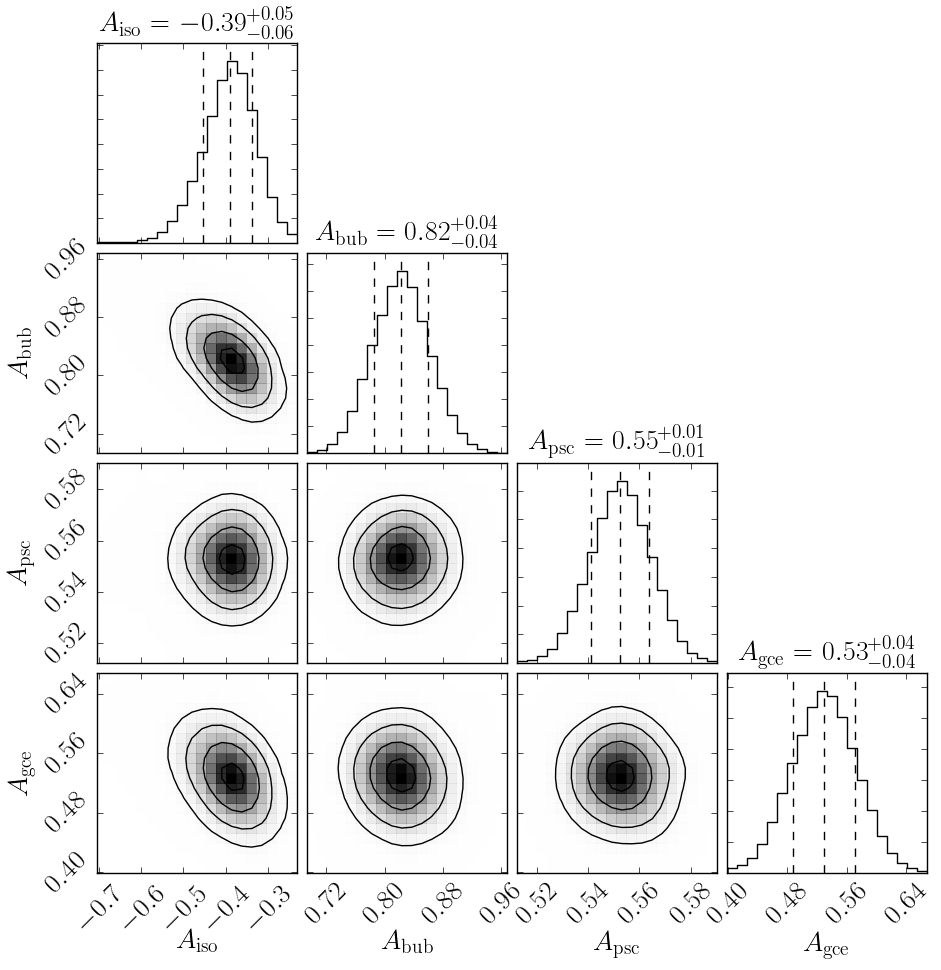

In [10]:
n.load_scan()
an = dnds_analysis.dnds_analysis(n)
an.make_triangle()

The triangle plot makes it clear that a non-zero value of the GCE template is preferred by the fit. Note also that as we gave the isotropic template a log flat prior, the parameter in the triangle plot is $\log_{10} A_\mathrm{iso}$.

We also show the relative fraction of the Flux obtained by the GCE as compared to other templates. Note the majority of the flux is absorbed by the diffuse model.

(0, 8)

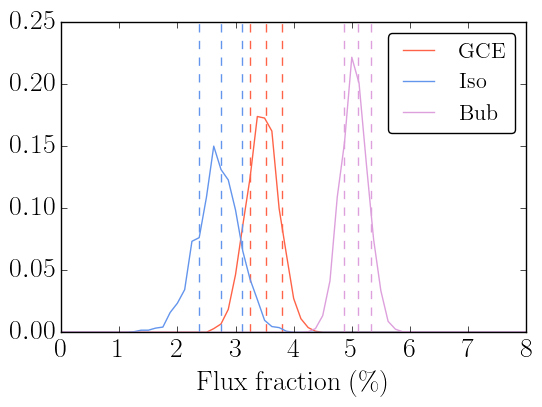

In [11]:
an.plot_intensity_fraction_poiss('gce', bins=800, color='tomato', label='GCE')
an.plot_intensity_fraction_poiss('iso', bins=800, color='cornflowerblue', label='Iso')
an.plot_intensity_fraction_poiss('bub', bins=800, color='plum', label='Bub')
plt.xlabel('Flux fraction (%)')
plt.legend(fancybox = True)
plt.xlim(0,8)